## Introduction

I'm interested in what a typical default with *Afterpay* looks like. I have probably read hundreds of pages of information published by *Afterpay*, but I'm yet to see them mention the average default size.

Because I'm curious, and I'm looking for a way to entertain myself on a long train ride, I decided to try and work it out myself.



:::{.callout-important}

Obviously, I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.

:::


## What do we know?
* Late Fees Revenue: 46.1 million AUD (Page 54 FY2019 Annual report)
* Average Transaction Value: Approximately 150 AUD (Page 25 FY2019 Annual report)
   
Furthermore, we know that the lowest and highest fee you can charge for a single transaction is 10 AUD and 68 AUD. Hence, this, in turn, bounds the average of the late fees.


![Page 43 of the Afterpay FY2019 Annual Report](../images/2020-08-21-Afterpay-Customer-Defaults-Part-1/Page43.png)


Let's spend a minute thinking about the different paths a transaction could take.

1. The customer makes good on all their payments, on time.

2. The customer makes no payments, including late fees.

3. The customer is continually late making payments but, in the end, makes all the payments required.

4. A combination of 2 and 3, where the customer makes some payments before ultimately defaulting.


In cases 2 and 4, there will be a contribution to *GROSS LOSS* (Afterpay doesn't get paid what's owed in full).

In the case of 3 and 4, there will be a contribution to *LATE FEES* (Afterpay doesn't get paid on time).

I will use PyMC3 to perform a *Monte Carlo* simulation, estimating how often cases 3 and 4 occur. 

In [1]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import scipy

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')

While not strictly necessary, I'm modelling "underlying_sales_aud", "late_fees_rev_aud" and "average_transaction_value_aud" as random variables so that they show up in the variable graph.

I'm also going to model *average_transaction_value_aud*, assuming they have rounded to the nearest 10 AUD.

In [2]:
with pm.Model() as model:
    underlying_sales_aud = pm.Uniform('underlying_sales_aud', lower=5.24715*10**9, upper=5.247249*10**9)
    
    late_fees_rev_aud = pm.Uniform('late_fees_rev', lower=46.05 * 10**6, upper=46.149 * 10**6)
    
    average_transaction_value_aud = pm.Uniform('average_transaction_value', lower=144.50, upper=154.49)
    
    average_late_fee_aud = pm.Uniform('average_late_fee',lower = 10, upper = 68)
    
    number_of_transactions = pm.Deterministic('number_of_transactions', underlying_sales_aud / average_transaction_value_aud)
    
    late_payment_rate = pm.Deterministic('late_payment_rate',late_fees_rev_aud / (number_of_transactions * average_late_fee_aud))
    

Now that we have instantiated all of the random variables, we will take 50,000 draws from them to perform our *Monte Carlo* simulation.

In [3]:
with model:
    samples = pm.sample_prior_predictive(samples=50_000, random_seed=0)

## Variable Graph

We can graph the relationship between all our variables. From this, we can quickly see which variables are critical dependencies. 

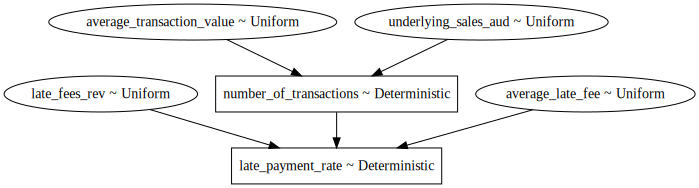

In [4]:
pm.model_to_graphviz(model)

## Results

We can now visualise the distribution of possible values for the late payment rate. 

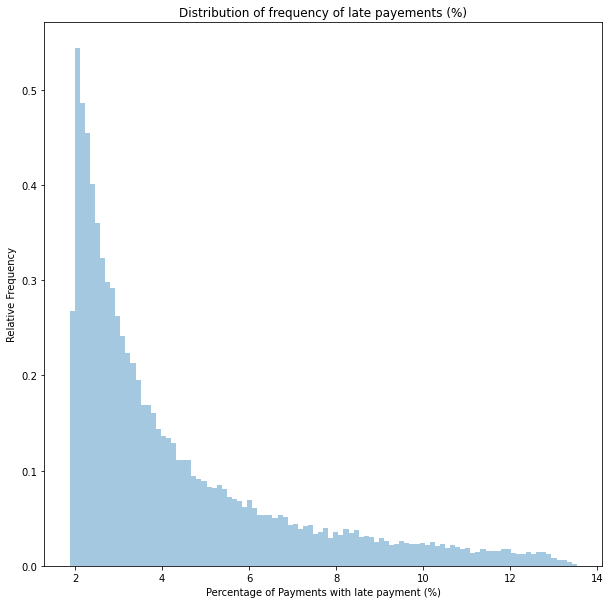

In [5]:
sns.distplot(100*samples["late_payment_rate"], kde=False, norm_hist=True, bins=100)
plt.title('Distribution of frequency of late payements (%)')
plt.xlabel('Percentage of transactions with late payment (%)')
plt.ylabel('Relative Frequency')
plt.show()

From this chart, we can see a high *likelihood*  the value of this parameter is bounded between 2 and 14%.

We can find a 94% chance the value is between 1.9% and 9.8% using PyMC3's summary function.

In [6]:
pm.summary(samples['late_payment_rate'])

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.043,0.025,0.019,0.097,0.0,0.0,48586.0,47975.0,49350.0,46251.0,NaN


## Conclusion
Based on our assumptions, we can get a high-level understanding of how common it is for *Afterpay* customers to be late in payment. Based on our model and assumptions, it's approximately 4.3% of the time. However, this is almost certainly wrong  because:

We made several implicit assumptions:
 1. All payments are the same size.
 2. The average late fee is uniformly distributed between 10 AUD and 68 AUD.
 
In future posts, I want to further refine the model, build a more accurate distribution, narrow itsbounds, and try atodetermine a result we can have more confidence in.